In [18]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# 1. Load datas

In [4]:
# set paths
sp_data_folder = '/home/jsw/BI/Database/Ravi_Cancer_Cell_2022/10XVisium_2/'
results_folder = './results/'

regression_model_output = 'RegressionModelOutput'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

def read_and_qc(sample_name, path = sp_data_folder):
    r'''Reads the data for one 10X spatial experiment into the anndata object
    It also calculates QC metrics
    
    :param sample_name: Name of the sample
    :param path: path to data
    '''
    adata = sc.read_visium(path + str(sample_name) + '/outs/',
                           count_file = 'filtered_feature_bc_matrix.h5', load_images = True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns = {'gene_ids': 'ENSEMBL'}, inplace = True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns = 'ENSEMBL', inplace = True)
    
    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    adata.X = adata.X.toarray()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.X = csr_matrix(adata.X)
    adata.var['MT'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['MT_frac'] = adata[:, adata.var['MT'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # add sample name to obs names
    adata.obs['sapmle'] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs['sample'] + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata


def select_slide(adata, s, s_col = 'sample'):
    r'''Selets the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    '''
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]
    
    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

In [7]:
# read csv and store the first column as list
import pandas as pd
sample_data = pd.read_csv('../spatial_data.csv')
sample_data['combined_id'] = sample_data['ID'] + '_' + sample_data['Tissue_Type'] + '_ST'

In [11]:
slides = []
for combined_id in sample_data['combined_id']:
    slides.append(read_and_qc(combined_id))
    
# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key='sample',
    uns_merge='unique',
    batch_categories=sample_data['combined_id'],
    index_unique=None
)

# replace the sample names with the new names
spatial_to_sample = pd.read_csv('../spatial_to_sample.csv')
for index, row in spatial_to_sample.iterrows():
    old_key = row['old']
    new_key = row['new']
    if old_key in adata.uns['spatial']:
        adata.uns['spatial'][new_key] = adata.uns['spatial'].pop(old_key)
    

/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_m

/tmp/ipykernel_13103/632334807.py:51: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_13103/632334807.py:51: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_13103/632334807.py:51: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_13103/632334807.py:51: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_13103/632334807.py:51: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial

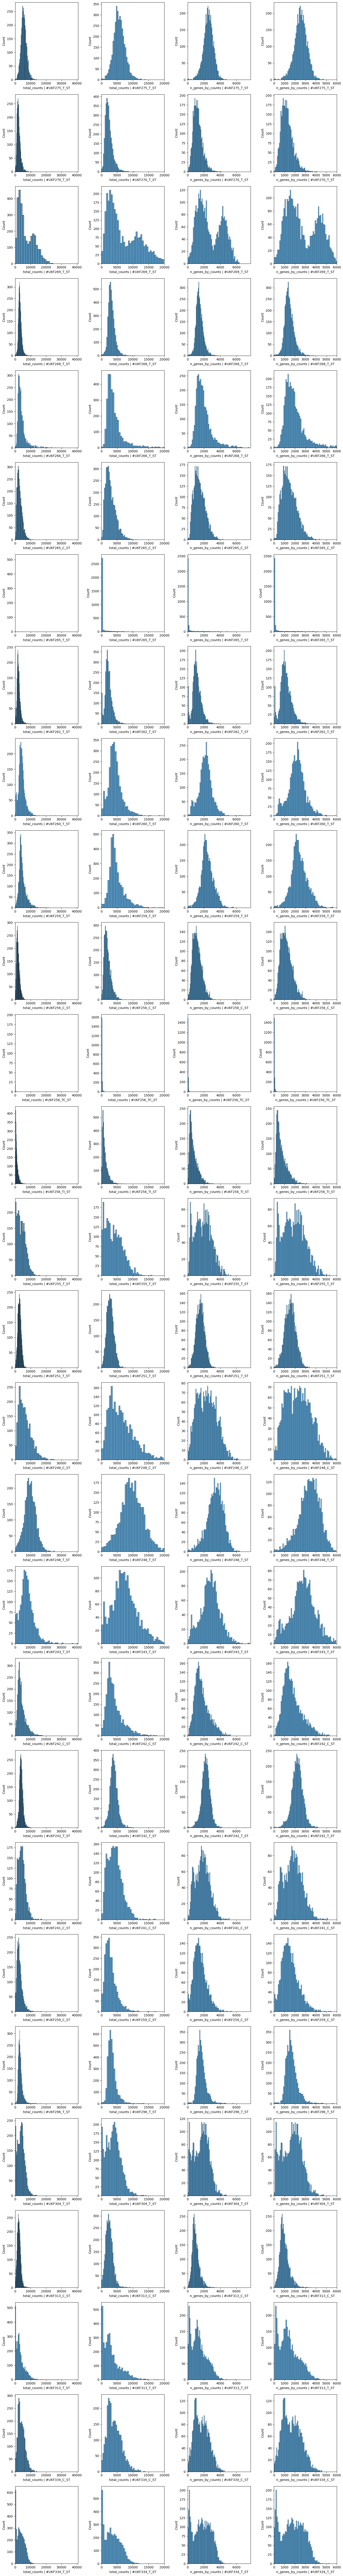

In [14]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    slide = select_slide(adata, s)
    
    sns.histplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.histplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.histplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.histplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

---
# Visualize

/tmp/ipykernel_13103/632334807.py:51: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}


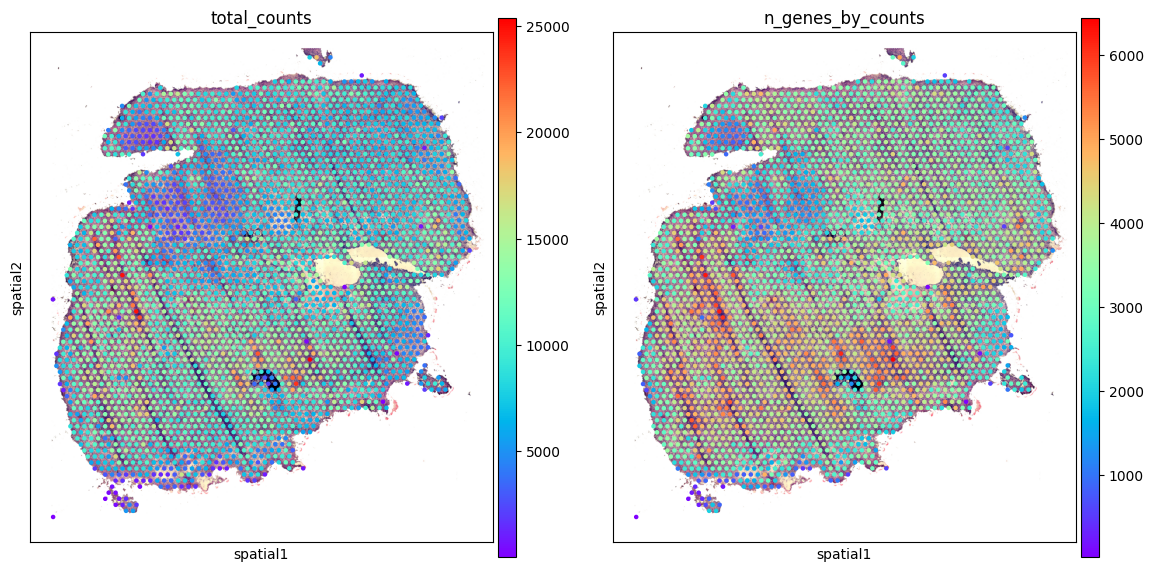

In [58]:
slide = select_slide(adata, '#UKF248_T_ST')

with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(slide, img_key = "hires", cmap='rainbow',
                  library_id=list(slide.uns['spatial'].keys())[0],
                  color=['total_counts', 'n_genes_by_counts'], size=1,
                  gene_symbols='SYMBOL', show=False, return_fig=True)

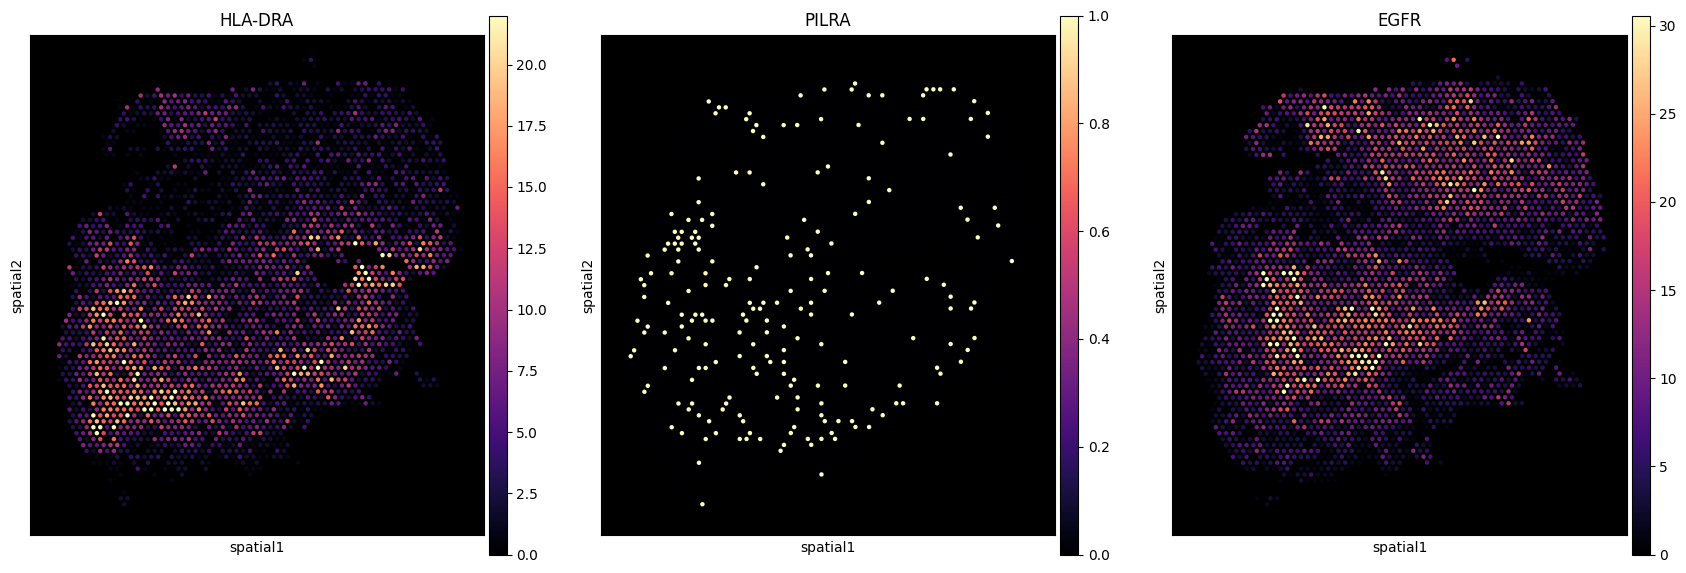

In [82]:
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(slide,
                  color=["HLA-DRA", "PILRA", "EGFR"], img_key=None, size=1,
                  vmin=0, cmap='magma', vmax='p99.0',
                  gene_symbols='SYMBOL'
                 )

---
# cell2location

In [43]:
# Select the slide for further analysis
adata_vis = adata.copy()
adata_vis.raw = adata_vis

In [ ]:
# select one visium slide
s = ['#UKF265_C_ST', '#UKF265_T_ST']
adata_vis = adata_vis[adata_vis.obs['sample'].isin(s), :]

In [15]:
import cell2location
from cell2location.models import RegressionModel

/home/jsw/jswenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-08 15:11:37.577500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 15:11:37.583938: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 15:11:37.585841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 15:11:38.132949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find

In [ ]:
# Load scRNA-seq reference data
sc_ref_data = sc.read_h5ad('../data/adata_annotated.h5ad')


NameError: name 'adata_list' is not defined

In [33]:
# sc_ref_data로부터 세포 유형 특성 추정
cell2location.models.RegressionModel.setup_anndata(sc_ref_data, labels_key='cell_type', layer = 'counts')


In [34]:
print(sc_ref_data)

AnnData object with n_obs × n_vars = 3261 × 17282
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'leiden', 'tumor_cell', 'cnv_leiden', 'cnv_score', 'cell_type', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'chromosome', 'start', 'end', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'cell_type_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'tumor_cell_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'


In [35]:
regression_model = RegressionModel(sc_ref_data)
regression_model.train(max_epochs = 250)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to impro

Epoch 250/250: 100%|██████████| 250/250 [00:45<00:00,  5.55it/s, v_num=1, elbo_train=2.81e+7]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [00:45<00:00,  5.45it/s, v_num=1, elbo_train=2.81e+7]
